### LIME for images

For images, it is not a good idea to perturb individual pixels to understand the behaviour of our model. This is because many more than one pixel contribute to one class. Randomly changing individual pixels would probably not change the predictions by much. Therefore, variations of the images are created by **segmenting** the image into **“superpixels”** and turning superpixels off or on. Let us take a detour and briefly discuss superpixels.   

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. More formally,

**Superpixel.** Superpixels are an **oversegmentation** of an image. A superpixel is a perceptual grouping of pixels. Instead of finding segments that correspond to objects (as done in instance segmentation), superpixel segmentation algorithms split the image into typically a few hundered (eg., 2500) segments. The objective of this oversegmentation is to partition the image such that **1)** no superpixel is split by an object boundary, **2)** while objects may be divided into multiple superpixels.



The LIME algorithm for images uses super-pixels as image features to interpret a black-box model. Let's see how.


### Setting up 

As always, we start by loading relevant packages. From the LIME package, we import lime_image. We also make use of the skimage package for visualization. See the instructions below. 

In [1]:
import json
import os
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision.models import resnet18
import torchvision.transforms as T
import torch.nn.functional as F

# reading lime_image
from lime import lime_image

from skimage.segmentation import mark_boundaries 

In [2]:
# Set random seed for reproducibility.
np.random.seed(0)
torch.manual_seed(0) 
device ="cuda:0" if torch.cuda.is_available() else "cpu"

## Interpreting ResNet model

We focus on interpreting ResNet model. Below, we load the model. We also need the class descriptions for the ImageNet dataset which the ResNet is trained on. This information is available in a json file which again we read below.

In [4]:
# loading the model
resnet = resnet18(pretrained=True)
resnet = resnet.eval().to(device)

In [5]:
# Reading imagenet classes
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.join(".","imagenet_class_index.json"), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

### Utility functions

We need to develop a couple of utility function. Below, we implement a function to read an image and construct a torch tensor for the ResNet model. We recall that the ResNet model requires images to be normalized (RGB channels). 

We also need a function to convert an image to a torch tensor withoiut normalizing. The latter is used with the LIME package.  

In [14]:
# Resize and take the center part of image to what our model expects
def pil_to_torch(img):
    transf = T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]) 
    ])        
    # Unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

def pil_transform(img): 
    transf = T.Compose([
        T.Resize((256, 256)),
        T.CenterCrop(224)
    ])    

    return transf(img)

### Utility function for LIME

We need to write a utility function to work with LIME. LIME will provide us with images where superpixels will turn-on and off and requires predictions in the form of class-probabilities to train its local model. hence, we need to write a function that gets images in the form of numpy arrays and make predictions using our ResNet model. 

In [15]:
def cnn_predict(images): 
    transf = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
        ])
    
    batch = torch.stack(tuple(transf(img) for img in images), dim=0)

    logits = resnet(batch.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

### Read an image

Below, we read the "puppy_kitten.jpg" from the data folder and display it.

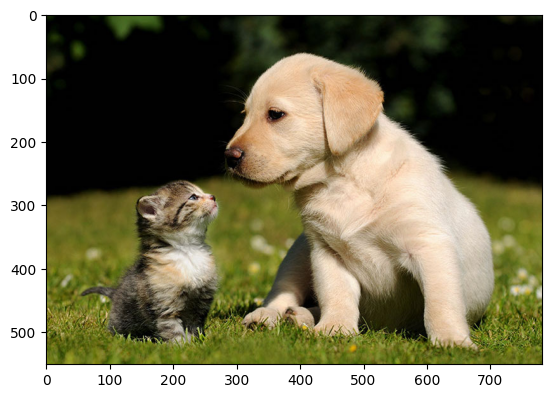

In [16]:
img_file_name = "puppy_kitten.jpg"
img_pil_0 = Image.open(os.path.join(".",img_file_name)).convert('RGB')

_ = plt.imshow(img_pil_0)

### ResNet predicts as?

Let's see how the ResNet will recognize the image, is it a cat or a dog?

In [28]:
img0 = pil_to_torch(img_pil_0)

logits = resnet(img0.to(device))
probs = F.softmax(logits, dim=1).cpu()

tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.49298906, 208, 'Labrador_retriever'),
 (0.26647267, 207, 'golden_retriever'),
 (0.06346101, 222, 'kuvasz'),
 (0.032335218, 257, 'Great_Pyrenees'),
 (0.023868795, 170, 'Irish_wolfhound'))

### Use LIME to explain the ResNet

To use LIME, we need to first define an explainer object. Check the cell below for this purpose.
Then, we can use the method [explain_instance](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image) from the explainer object to understand the behaviour of Resnet. Run the "explain_instance" and discuss the results. 

In [30]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(img_pil_0)), 
                                         cnn_predict, # Classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000) # Number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

After running LIME on our image, you can use various methods to visualize which parts of the image contributed to the decisions. Check the method [get_image_and_mask](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_image.ImageExplanation.get_image_and_mask) which can be used to visualize superpixels that **positively** or **negatively** contribute to the prediction of the label.

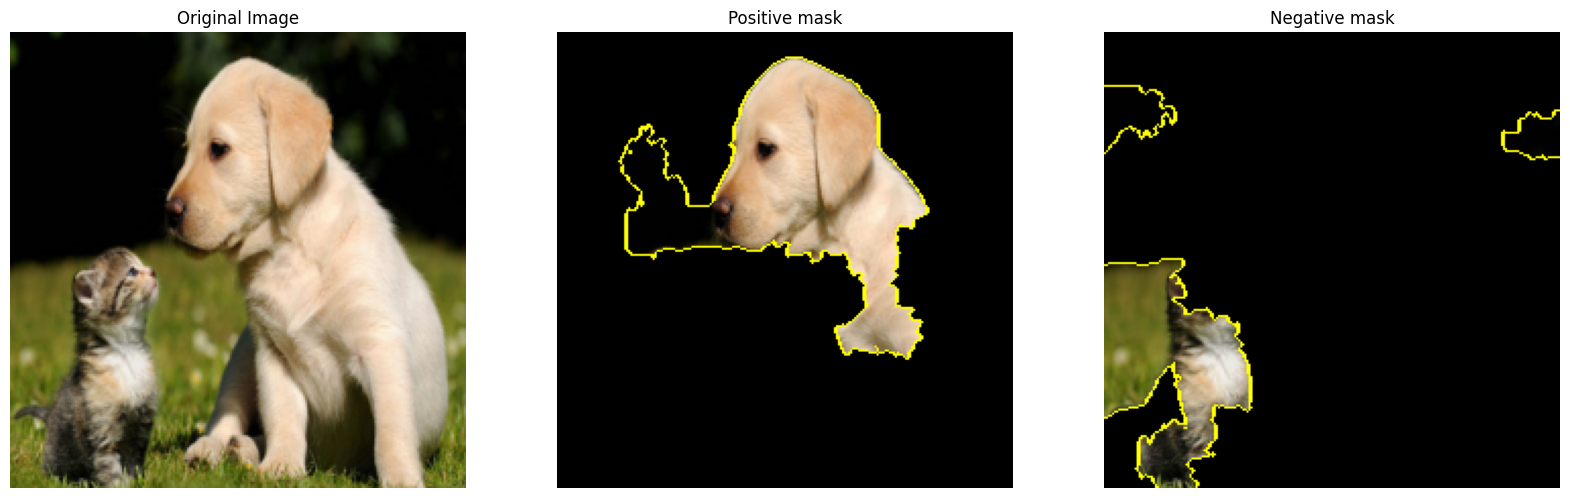

In [31]:
fig, axes = plt.subplots(1,3, figsize=(20, 10))

axes[0].imshow(pil_transform(img_pil_0))
axes[0].axis('off')
axes[0].set_title("Original Image")

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, negative_only=False, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[1].imshow(img_boundry)
axes[1].set_title("Positive mask")
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, negative_only=True, 
                                            num_features=5, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[2].imshow(img_boundry)
axes[2].set_title("Negative mask")
axes[2].axis('off')

plt.show()

## Lets try another image!

In [34]:
img_file_name = "fruit.jpg"
img_pil_1 = Image.open(os.path.join(".",img_file_name)).convert('RGB')

img1 = pil_to_torch(img_pil_1)
logits = resnet(img1.to(device)).cpu()
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)

((0.6808233, 588, 'hamper'),
 (0.15997502, 790, 'shopping_basket'),
 (0.035771657, 954, 'banana'),
 (0.03570169, 951, 'lemon'),
 (0.027229114, 953, 'pineapple'))

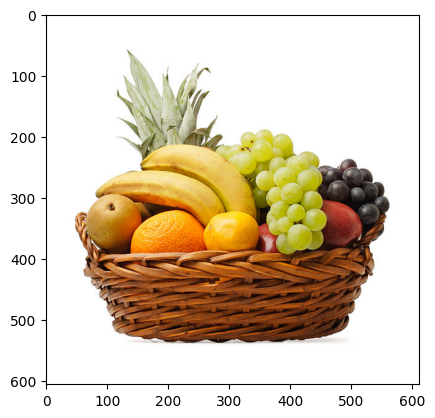

In [35]:
_ = plt.imshow(img_pil_1)
labels = tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))
labels

In [36]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pil_transform(img_pil_1)), 
                                         cnn_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function


  0%|          | 0/1000 [00:00<?, ?it/s]

Looking at: lemon


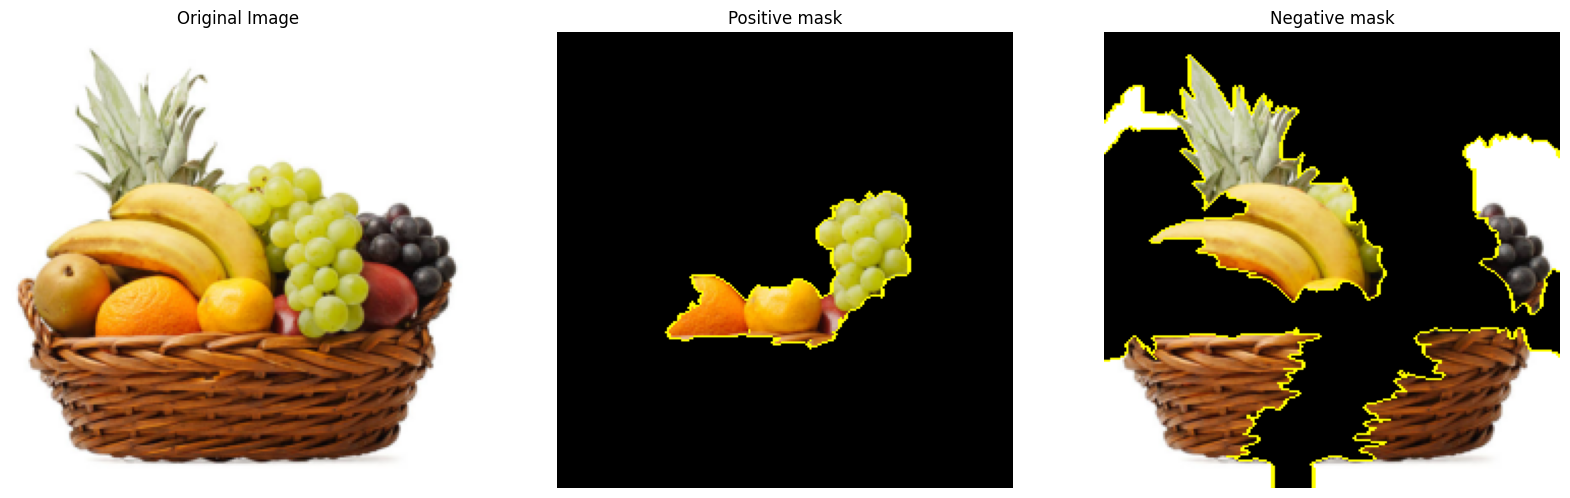

In [37]:
label = 3
print("Looking at:", labels[label][-1])

fig, axes = plt.subplots(1,3, figsize=(20, 10))
axes[0].imshow(pil_transform(img_pil_1))
axes[0].axis('off')
axes[0].set_title("Original Image")

temp, mask = explanation.get_image_and_mask(explanation.top_labels[label], positive_only=True, 
                                            negative_only=False, num_features=3, hide_rest=True)
img_boundry = mark_boundaries(temp/255.0, mask)
axes[1].imshow(img_boundry)
axes[1].set_title("Positive mask")
axes[1].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[label], positive_only=False, 
                                            negative_only=True, num_features=10, hide_rest=True)

img_boundry = mark_boundaries(temp/255.0, mask)
axes[2].imshow(img_boundry)
axes[2].set_title("Negative mask")
axes[2].axis('off')

plt.show()